## 2.3.(1)

简单的线性规划

In [13]:
import numpy as np
import pulp

x = np.array([1.25, 8.75, 0.5, 5.75, 3, 7.25]) # 工地坐标x
y = np.array([1.25, 0.75, 4.75, 5, 6.5, 7.75]) # 工地坐标y
demand = np.array([3, 5, 4, 7, 6, 11]) # 需求量

A = np.array([5,1]) # 料场A坐标
B = np.array([2,7]) # 料场B坐标

# 计算A、B到各个需求点的距离
distance_a = np.sqrt((x - A[0])**2 + (y - A[1])**2)
distance_b = np.sqrt((x - B[0])**2 + (y - B[1])**2)

# A与B各有20t的货物
A_supply = 20
B_supply = 20

# minimize吨公里数，𝐴, 𝐵两料场分别向各工地运送多少吨
model = pulp.LpProblem("Minimize_Transportation_Cost", pulp.LpMinimize)
a_vars = [pulp.LpVariable(f"x_{i}", lowBound=0, upBound=A_supply) for i in range(len(demand))]
b_vars = [pulp.LpVariable(f"y_{i}", lowBound=0, upBound=B_supply) for i in range(len(demand))]

# 目标函数：最小化运输成本
model += pulp.lpSum([distance_a[i] * a_vars[i] + distance_b[i] * b_vars[i] for i in range(len(demand))]), "Total_Transportation_Cost"

# 约束条件：每个需求点的需求量必须满足
for i in range(len(demand)):
    model += a_vars[i] + b_vars[i] == demand[i], f"Demand_Constraint_{i}"
    
# 约束条件：A、B的供应量不能超过各自的最大供应量
model += pulp.lpSum(a_vars) <= A_supply, "Supply_Constraint_A"
model += pulp.lpSum(b_vars) <= B_supply, "Supply_Constraint_B"

# 求解模型
model.solve()

# 输出结果
print("Status:", pulp.LpStatus[model.status])
print("Total Transportation Cost:", pulp.value(model.objective))
for i in range(len(demand)):
    print(f"Amount transported from A to site {i}: {a_vars[i].varValue} tons")
    print(f"Amount transported from B to site {i}: {b_vars[i].varValue} tons")
print(f"Total amount transported from A: {pulp.value(pulp.lpSum(a_vars))} tons")
print(f"Total amount transported from B: {pulp.value(pulp.lpSum(b_vars))} tons")


Status: Optimal
Total Transportation Cost: 136.22751988318157
Amount transported from A to site 0: 3.0 tons
Amount transported from B to site 0: 0.0 tons
Amount transported from A to site 1: 5.0 tons
Amount transported from B to site 1: 0.0 tons
Amount transported from A to site 2: 0.0 tons
Amount transported from B to site 2: 4.0 tons
Amount transported from A to site 3: 7.0 tons
Amount transported from B to site 3: 0.0 tons
Amount transported from A to site 4: 0.0 tons
Amount transported from B to site 4: 6.0 tons
Amount transported from A to site 5: 1.0 tons
Amount transported from B to site 5: 10.0 tons
Total amount transported from A: 16.0 tons
Total amount transported from B: 20.0 tons


## 2.3.(2)

联合优化料场位置 + 分配方案

带有位置变量的最优化问题（经典的设施选址问题！）

In [14]:
from scipy.optimize import linprog, minimize
import numpy as np

# 工地数据
x = np.array([1.25, 8.75, 0.5, 5.75, 3, 7.25])
y = np.array([1.25, 0.75, 4.75, 5, 6.5, 7.75])
demand = np.array([3, 5, 4, 7, 6, 11])
n = len(demand)

# 内层线性规划：给定两个料场位置，计算最小吨公里数
def compute_ton_km(P1, P2):
    dA = np.sqrt((x - P1[0])**2 + (y - P1[1])**2)
    dB = np.sqrt((x - P2[0])**2 + (y - P2[1])**2)

    # 变量顺序：[a_1, ..., a_6, b_1, ..., b_6] 共12个变量
    c = np.concatenate([dA, dB])

    # 等式约束：a_i + b_i = demand[i]
    A_eq = np.zeros((n, 2*n))
    for i in range(n):
        A_eq[i, i] = 1
        A_eq[i, i + n] = 1
    b_eq = demand

    # 不等式约束：sum(a_i) <= 20, sum(b_i) <= 20
    A_ub = np.zeros((2, 2*n))
    A_ub[0, :n] = 1
    A_ub[1, n:] = 1
    b_ub = [20, 20]

    bounds = [(0, None)] * (2*n)

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds)
    return res.fun if res.success else np.inf

# 外层优化：找到两个料场的位置
def total_ton_km(pos):
    P1 = pos[:2]
    P2 = pos[2:]
    return compute_ton_km(P1, P2)

# 初始猜测位置（题目中 A 和 B）
x0 = [5, 1, 2, 7] # x0为初始猜测位置
res = minimize(total_ton_km, x0, bounds=[(0, 10)]*4)

print("最优料场位置：", res.x)
print("最小吨公里数：", res.fun)


最优料场位置： [7.24999999 7.75000001 3.25472582 5.65238561]
最小吨公里数： 85.26604112549687


## 2.3.(2) 补充

怀疑这个点不是最优的，可能是局部最优解

In [ ]:
from tqdm import tqdm
res_xs = []
res_funs = []
total = 100

# 怀疑可能陷入局部最优
tqdm = tqdm(total=total, desc="优化进度") # 进度条
for i in range(total):
    tqdm.update(1) # 进度条更新
    x0 = [np.random.uniform(0, 10) for _ in range(4)] # 均匀随机生成初始猜测位置
    res = minimize(total_ton_km, x0, bounds=[(0, 10)]*4)
    res_xs.append(res.x)
    res_funs.append(res.fun)
tqdm.close() # 进度条关闭



优化进度: 100%|██████████| 100/100 [00:54<00:00,  1.82it/s]


In [43]:
# 假设 res_xs 是一个 np.array，shape 为 (100, 4)  
res_xs = np.array(res_xs)  

# 确保每对点 A 和 B 的 x 坐标顺序  （让左侧的是A）
for i in range(res_xs.shape[0]):  
    A_x = res_xs[i, 0]  
    B_x = res_xs[i, 2]  
    
    if A_x >= B_x:  
        # 交换这两个点  
        res_xs[i, 0], res_xs[i, 2] = res_xs[i, 2], res_xs[i, 0]  
        res_xs[i, 1], res_xs[i, 3] = res_xs[i, 3], res_xs[i, 1]  


# 将x坐标小的点放在前面,res_funs也按顺序排列
res_funs = np.array(res_funs)[np.argsort(res_xs[:, 0])]
res_xs = res_xs[np.argsort(res_xs[:, 0])]

print("所有最优料场位置：", res_xs)
print("所有最小吨公里数：", res_funs)

print("最小吨公里数的最优解：", np.min(res_funs))
print("最优料场位置的最优解：", res_xs[np.argmin(res_funs)])

所有最优料场位置： [[2.99999877 6.4999974  5.90565256 5.07307205]
 [2.99999991 6.49999992 5.92079884 5.08058337]
 [2.99999999 6.49999996 5.90567993 5.073055  ]
 [3.23804763 5.68874412 7.25000011 7.75000003]
 [3.24520854 5.64353718 7.24999999 7.75000001]
 [3.24664152 5.70589537 7.25000001 7.74999998]
 [3.24803613 5.67002881 7.25       7.74999996]
 [3.24868169 5.67111923 7.25000001 7.75000001]
 [3.24967786 5.62718473 7.24999999 7.74999998]
 [3.25138035 5.64414629 7.25       7.74999999]
 [3.25202842 5.65382377 7.25       7.74999999]
 [3.25281052 5.6632057  7.24999999 7.74999999]
 [3.25333296 5.66165551 7.25000001 7.74999999]
 [3.25361623 5.65426346 7.25000001 7.75      ]
 [3.25388682 5.65136177 7.24999998 7.74999998]
 [3.25392235 5.65334359 7.25000001 7.74999998]
 [3.2541379  5.65370669 7.25000003 7.75      ]
 [3.25417267 5.65338693 7.25000001 7.74999998]
 [3.25421473 5.65205909 7.25       7.74999999]
 [3.25432948 5.65409209 7.24999997 7.75000001]
 [3.25450457 5.65513096 7.25000003 7.74999996]
 [3

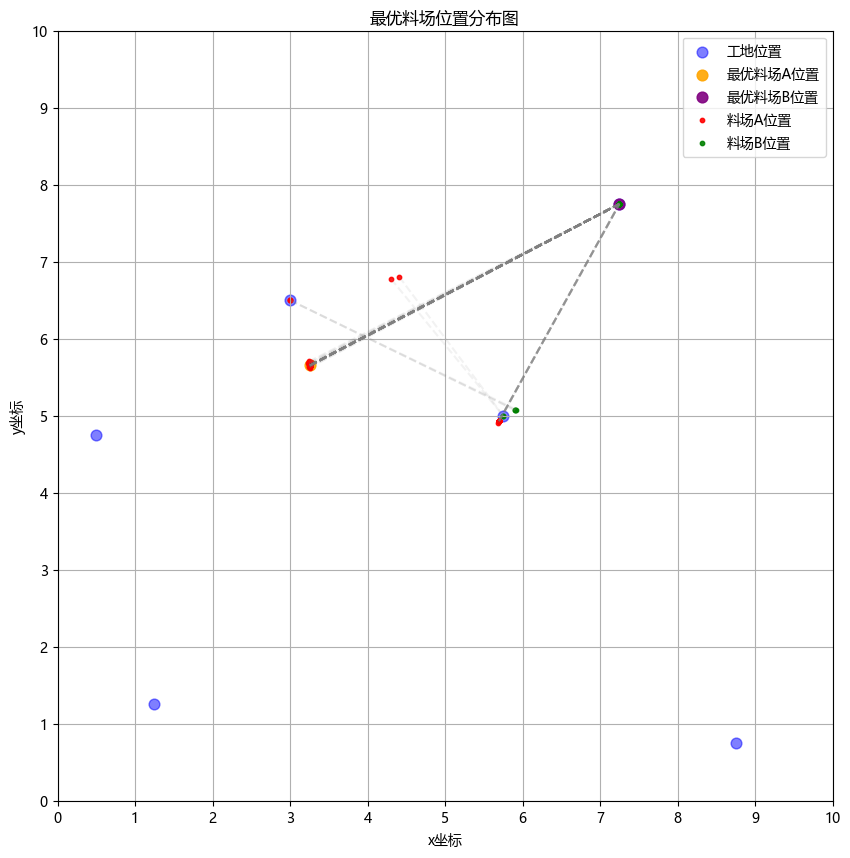

In [44]:
# 画出这些res_xs最优解的a与b点
from matplotlib import cm
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(10, 10))
plt.title("最优料场位置分布图")
plt.xlabel("x坐标")
plt.ylabel("y坐标")
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xticks(np.arange(0, 11, 1))
plt.yticks(np.arange(0, 11, 1))
plt.grid()

plt.scatter(x, y, c='blue', alpha=0.5, s=60, label='工地位置')
plt.scatter(res_xs[np.where(res_funs == min(res_funs))[0][0]][0], res_xs[np.where(res_funs == min(res_funs))[0][0]][1], c='orange', alpha=0.9, s=60, label='最优料场A位置')
plt.scatter(res_xs[np.where(res_funs == min(res_funs))[0][0]][2], res_xs[np.where(res_funs == min(res_funs))[0][0]][3], c='purple', alpha=0.9, s=60, label='最优料场B位置')
plt.scatter(res_xs[:,0], res_xs[:,1], c='red', alpha=0.9, s=10, label='料场A位置')
plt.scatter(res_xs[:,2], res_xs[:,3], c='green', alpha=0.9, s=10, label='料场B位置')
# 连接料场A和B的线
for i in range(len(res_xs)):
    plt.plot([res_xs[i][0], res_xs[i][2]], [res_xs[i][1], res_xs[i][3]], c='gray', alpha=0.1, linestyle='--')

plt.legend()
plt.show()
